# Nedir bu GANs ?
* Eğitim setiyle aynı istatistiklere sahip, gerçeğinden ayırt edilemez yeni veriler üreten yapılardır.

* GANs içerisinde 2 network vardır:
  * **Generator**(Üretici ağ)         => Resimleri başlangıçta saçma sapan üreten, zamanla gerçek haline benzetmeye çalışan, yeni veri üreten yapı. (**Kalpazan**)
  * **Discriminator**(Ayırt edici ağ) => Classifier görevi var. Üretilen data gerçek mi değil mi diye sorgulayacak. (**Dedektif**)
* Zamanla Generator o kadar güzel resimler üretecek ki Discriminator fake mi gerçek mi anlayamayacak, Discriminator'u kandırmaya başlayacak! :)
* <img src="img/gans.png">
* <img src="img/gans2.png">
* <img src="img/gans3.png">
* <img src="img/gans4.png">

## Sample Articles
- https://arxiv.org/pdf/1708.05509.pdf
- https://arxiv.org/pdf/1609.04802.pdf
- https://arxiv.org/pdf/1704.04086.pdf
- https://github.com/pathak22/context-encoder
- https://github.com/hanzhanggit/StackGAN

In [1]:
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

## 1-Read Data and Preprocessing

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# convert (-1,1) normalization
x_train = (x_train.astype(np.float32)-127.5)/127.5
x_train.shape

(60000, 28, 28)

In [4]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_train.shape

(60000, 784)

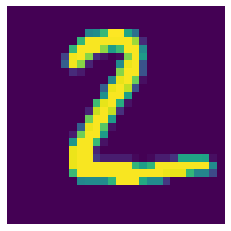

In [5]:
plt.imshow(x_test[1])
plt.axis("Off")
plt.show()

## 2-Create and Compile Generator Model
<img src="img/generator.png">

In [6]:
def create_generator():
    generator = Sequential()

    generator.add(Dense(units = 512, input_dim = 100))
    generator.add(ReLU())
    
    generator.add(Dense(units = 512))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 784, activation = "tanh"))
    
    # 2 output olduğu için binary
    generator.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.5))
    return generator

In [7]:
g = create_generator()
g.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

## 3-Create and Compile Discriminator Model
<img src="img/discriminator.png">

In [8]:
def create_discriminator():
    discriminator = Sequential()

    discriminator.add(Dense(units=1024, input_dim = 784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units=512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units=256))
    discriminator.add(ReLU())
    
    discriminator.add(Dense(units=1, activation = "sigmoid")) # 1 neron=output
    
    # beta_1=1. an tahminleri için üstel bozulma oranı. default=0,9
    discriminator.compile(loss = "binary_crossentropy",
                          optimizer= Adam(learning_rate = 0.0001, beta_1 = 0.5))
    return discriminator

In [9]:
d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 re_lu_3 (ReLU)              (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_4 (ReLU)              (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

## 4-Create and Compile GANs Model
<img src="img/gans5.png">

In [10]:
def create_gan(discriminator, generator):
    discriminator.trainable = False # generatorun zamanla doğru resimler üretebilmesi için, d'nin train edilemez olması gerek.
    
    gan_input = Input(shape=(100,))
    
    # x = generatorun outputu
    x = generator(gan_input) 

    # generatorun outputu, discriminatorun inputudur.
    gan_output = discriminator(x)
    
    gan = Model(inputs = gan_input, outputs = gan_output)
    
    gan.compile(loss = "binary_crossentropy", optimizer="adam")
    return gan

In [11]:
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1643280   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 3,103,505
Trainable params: 1,643,280
Non-trainable params: 1,460,225
_________________________________________________________________


## 5-Train Data
<img src="img/train.png">

In [12]:
epochs = 50
batch_size = 256

In [13]:
for e in range(epochs):
    for _ in range(batch_size):
        
        noise = np.random.normal(0,1, [batch_size,100])
        
        generated_images = g.predict(noise)
        
        # x_train'in ilk ve son indexi arasında random batch size kadar resim seçer.
        image_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)]
        
        # ilk 256 tanesi => gercek, son 256 tanesi => fake imageler olacak şekilde merge edilir.
        x = np.concatenate([image_batch, generated_images])
        
        # d'leri eğitmek için gerekli olan resimlerin labellarına(y) ihtiyaç var.
        y_dis = np.zeros(batch_size * 2) # 512 tane 0 oluşturur. (son 256 tanesi 0)
        y_dis[:batch_size] = 1 # ilk 256 tanesini 1 olarak güncellenir
        
        d.trainable = True # Artık eğitime başladık.
        d.train_on_batch(x, y_dis) # input olarak bu parametreler verilir.

        ######################## TRAIN GENERATOR ########################

        noise = np.random.normal(0, 1, [batch_size, 100]) # 0-1 arasında 256x100 lük bir noise oluşturulur.
        
        y_gen = np.ones(batch_size) # generator resimlerin gerçek resim olduğunu iddia ediyor, o yüzden 1'le doldurulur! :)
        
        d.trainable = False # artık generator eğitilecek.
        
        gan.train_on_batch(noise, y_gen) # input olarak bu parametreler verilir.
    print("epochs: ", e)
    
g.save('demo.h5')  # always save your weights after training or during training

epochs:  0
epochs:  1
epochs:  2
epochs:  3
epochs:  4
epochs:  5
epochs:  6
epochs:  7
epochs:  8
epochs:  9
epochs:  10
epochs:  11
epochs:  12
epochs:  13
epochs:  14
epochs:  15
epochs:  16
epochs:  17
epochs:  18
epochs:  19
epochs:  20
epochs:  21
epochs:  22
epochs:  23
epochs:  24
epochs:  25
epochs:  26
epochs:  27
epochs:  28
epochs:  29
epochs:  30
epochs:  31
epochs:  32
epochs:  33
epochs:  34
epochs:  35
epochs:  36
epochs:  37
epochs:  38
epochs:  39
epochs:  40
epochs:  41
epochs:  42
epochs:  43
epochs:  44
epochs:  45
epochs:  46
epochs:  47
epochs:  48
epochs:  49


## 6-Load Model

In [15]:
model1 = load_model("demo.h5")

## 7-Visualiza Data

In [16]:
noise = np.random.normal(loc=0, scale=1, size=[100, 100])
noise

array([[ 1.64509782, -0.35197548,  0.84913277, ...,  0.50153618,
         1.08220526, -3.28160216],
       [ 0.74994833, -0.23390685,  0.39053153, ...,  1.02768636,
        -0.83149205, -1.95445166],
       [-1.21841654, -0.81404729,  0.39729674, ..., -0.31197976,
         0.96442003,  0.34890993],
       ...,
       [-2.24545785,  0.55092833,  0.07647887, ...,  1.35136571,
        -1.5346627 ,  0.56883921],
       [-0.04048832,  1.83652184,  1.17422021, ...,  1.51133025,
        -0.66080862,  0.01275371],
       [-0.63695126,  1.07570348, -0.24085974, ...,  0.95549412,
         0.04997536,  0.35381645]])

- Aşağıdaki plotlarda yalnızca 50 epoch ile gerçeğe çok yakın resimler elde edilmiş olduk.

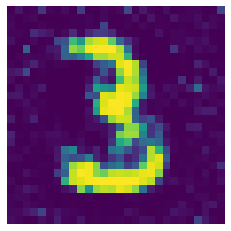

In [21]:
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100, 28, 28)
plt.imshow(generated_images[0], interpolation='nearest')
plt.axis('off')
plt.show() 